<a href="https://colab.research.google.com/github/nitsundon/Load-Forecast/blob/main/XGBoostModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy matplotlib scikit-learn tensorflow


In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


In [6]:
df=pd.read_pickle("/content/drive/MyDrive/Libraries/pickle/preprocessed_demand_df.pkl")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 96, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 175s 119ms/step - loss: 0.0105 - val_loss: nan
Epoch 2/10
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 211s 125ms/step - loss: 2.2490e-04 - val_loss: nan
Epoch 3/10
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 197s 122ms/step - loss: 1.2545e-04 - val_loss: nan
Epoch 4/10
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 197s 118ms/step - loss: 9.3736e-05 - val_loss: nan
Epoch 5/10
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 212s 126ms/step - loss: 9.6836e-05 - val_loss: nan
Epoch 6/10
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 199s 124ms/step - loss: 7.6636e-05 - val_loss: nan
Epoch 7/10
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 203s 124ms/step - loss: 8.0522e-05 - val_loss: nan
Epoch 8/10
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 178s 125ms/step - loss: 7.7193e-05 - val_loss: nan
Epoch 9/10
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 178s 125ms/step - loss: 7.7491e-05 - val_loss: nan
Epoch 10/10
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 178s 125ms/step - loss: 7.3522e-05 - val_loss: nan
712/712 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step


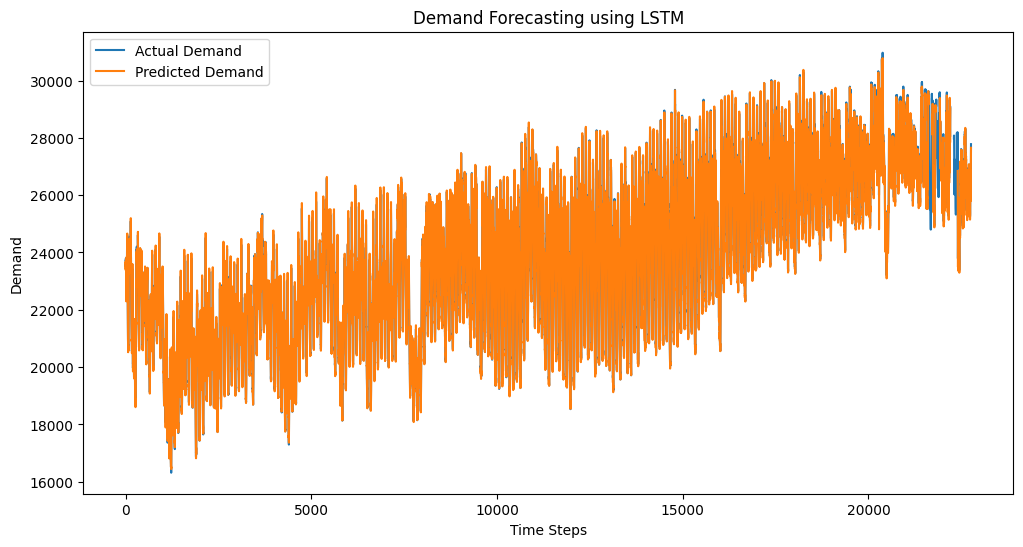

In [7]:
df.set_index('datetime', inplace=True)

# Resample if needed (e.g., hourly)
# df = df.resample('1H').mean()

# Normalize the demand values
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['demand']])

# Create sequences for LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 96  # past 1 day if data is at 15-min intervals
X, y = create_sequences(scaled_data, sequence_length)

# Train/test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape for LSTM input: [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# Predict
y_pred = model.predict(X_test)

# Inverse transform to get actual values
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# Plot
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual Demand')
plt.plot(y_pred_inv, label='Predicted Demand')
plt.title('Demand Forecasting using LSTM')
plt.xlabel('Time Steps')
plt.ylabel('Demand')
plt.legend()
plt.show()

In [9]:
y_pred_inv,y_test

(array([[23411.127],
        [23646.201],
        [23493.588],
        ...,
        [27131.18 ],
        [27400.3  ],
        [27652.879]], dtype=float32),
 array([[0.671978  ],
        [0.66880756],
        [0.67300792],
        ...,
        [0.83583706],
        [0.84831907],
        [0.85837845]]))